# Metropolis on alanine dipeptide with random intialization

**Anirudh Ghantasala, Datta Group, Purdue University**  
Last updated: 3-17-21  

1. Define the user parameters (timesteps)
2. Define a proposal distribution for particles based on the current state
3. Run simulation 


In [5]:
from openmmtools import mcmc, testsystems, states, cache
from simtk import openmm
from simtk import unit
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import mdtraj as md
import MDAnalysis
import MDAnalysis.analysis.rms


# user parameters ---------------------------------------------------
timesteps = 500
#--------------------------------------------------------------------

In [6]:
# Proposal Class, implements some logic that proposes a next state based on the current state (initial_positions)
class AddGaussianVector(mcmc.MetropolizedMove):
    def __init__(self, **kwargs):
        super(AddGaussianVector, self).__init__(**kwargs)

    def _propose_positions(self, initial_positions):
        
        ## PBIT MODULE#####
        # input: x,y,z
        # output: xp, yp, zp
        
        num_pbits = 18
        
        # read in initial positions (x,y,z) into pbits
        p = initial_positions.value_in_unit(unit.angstrom)
#         print('initial: ', p)
        x,y,z = round(p[0,0]*1000), round(p[0,1]*1000), round(p[0,2]*1000)
        binx = bin(x).replace("0b", "").zfill(num_pbits)
        biny = bin(y).replace("0b", "").zfill(num_pbits)
        binz = bin(z).replace("0b", "").zfill(num_pbits)
        
        #binxyz are strings
        
        # find gaussian probabilities to give p-bit gaussian generators
        x = np.arange(3,0, -3/num_pbits)
        y = np.exp(-1*pow(x,2)/2)/np.sqrt(2*np.pi)
        
        # flip pbits according to guassian probabilities, most_val first
        all_bin = []
        for num in [binx, biny, binz]:
            
            # create a gaussian binary noise vector and a sign bit
            pbits_flipped = ''

            for i in range(num_pbits):
                r = np.random.uniform(0,1)
                if r < y[i]:
                    pbits_flipped += '1'
                else:
                    pbits_flipped += '0'
            sign_bit = -1
            if np.random.uniform(0,1) < 0.5:
                sign_bit = 1;
            
            # add noise vector to current state
            all_bin.append(bin(int(num,2) + int(pbits_flipped,2)*sign_bit).replace("0b", "").zfill(num_pbits))
            
        # convert new state to integer
        decimals = []
        for i,val in enumerate(all_bin):
            decimals.append(int(val,2)/1000)
            
#         print('proposal: ', decimals)
        
        pbit_displacement = unit.Quantity(np.array(decimals), unit.angstrom)
        
        mean, var = 0, .01
        x_prop, y_prop, z_prop = np.random.normal(mean, var), np.random.normal(mean, var), np.random.normal(mean, var)
        displacement = unit.Quantity(np.array([x_prop, y_prop, z_prop]), initial_positions.unit)
        return initial_positions + displacement
#         return proposal

accepted 3171/11000: 


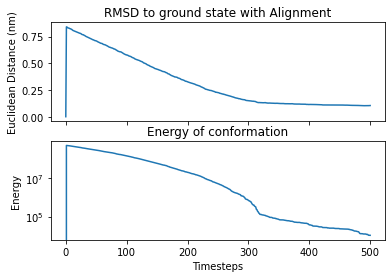

Simulation Complete!


In [7]:
def distance(x, correct):
    for k in range(3):
        x[:, k] -= np.mean(x[:, k])
        correct[:, k] -= np.mean(correct[:, k])
    noise = np.subtract(x, correct)
    return np.sqrt(np.sum(np.square(noise)))

# platform = openmm.Platform.getPlatformByName('CUDA')
# cache.global_context_cache.platform = platform

# Create the initial state (thermodynamic and microscopic) for an alanine dipeptide system in vacuum.
alanine = testsystems.AlanineDipeptideVacuum(constraints=None)
sampler_state = states.SamplerState(alanine.positions)
thermodynamic_state = states.ThermodynamicState(alanine.system, 1 * unit.kelvin)
e, d, rmsd, trajectory = [], [], [], []

context_cache = cache.global_context_cache
context, unused_integrator = context_cache.get_context(thermodynamic_state)
sampler_state.apply_to_context(context)

# initialize energy, distance, and trajectory
correct_state = sampler_state.positions.copy()
e.append(thermodynamic_state.reduced_potential(context))
d.append(distance(sampler_state.positions, sampler_state.positions))
trajectory.append(sampler_state.positions.copy())
rmsd.append(MDAnalysis.analysis.rms.rmsd(correct_state, correct_state, center=True, superposition=True))

# Add perterbance to correct state
for i, molecule in enumerate(sampler_state.positions):

    noise_low, noise_high = -1, 1
    sampler_state.positions[i][0] += unit.quantity.Quantity(value= np.random.uniform(noise_low, noise_high), unit=unit.nanometer)
    sampler_state.positions[i][1] += unit.quantity.Quantity(value= np.random.uniform(noise_low, noise_high), unit=unit.nanometer)
    sampler_state.positions[i][2] += unit.quantity.Quantity(value= np.random.uniform(noise_low, noise_high), unit=unit.nanometer)

# Create an update MCMC move that brings us back to the initial configuration.
current_state = sampler_state.positions.copy()
total_accepted, total_proposed = 0, 0

for ii in range(timesteps):
    for jj in range(sampler_state.n_particles):
        move = AddGaussianVector(atom_subset=[jj])
        move.apply(thermodynamic_state, sampler_state)
        if move.n_accepted == 1:
            total_accepted += 1
        total_proposed += 1

    # measure naive euclidean distance
    current_state = sampler_state.positions.copy()
    d.append(distance(current_state, correct_state))
    
    # measure energy
    sampler_state.apply_to_context(context, ignore_velocities=True)
    e.append(thermodynamic_state.reduced_potential(context))

    # build trajectory
    trajectory.append(current_state)

    # measure rmsd with alignment
    rmsd.append(MDAnalysis.analysis.rms.rmsd(current_state, correct_state, center=True, superposition=True))
    

print('accepted {}/{}: '.format(total_accepted, total_proposed))

fig, ((ax1),(ax2)) = plt.subplots(2, 1, sharex=True)
ax1.plot(rmsd, label='Euclidean dist')
ax1.set_title('RMSD to ground state with Alignment')
ax1.set_ylabel('Euclidean Distance (nm)')
ax2.plot(e, label='Energy')
ax2.set_yscale('log')
ax2.set_title('Energy of conformation')
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Energy')
# ax2.text(2, 10, r'Original Energy {}'.format(e[0]), fontsize=15)
plt.show()

print('Simulation Complete!')

In [8]:
# Visualize the simulation
traj = md.Trajectory(trajectory, topology=alanine.mdtraj_topology)
traj.save('trajectory.pdb')
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=500)

In [ ]:
# uncomment to select frame, reflects in above view
# view.frame = 0

# to download movie, open the saved .pdb file in pyMOL and file -> export movie as -> mpeg

## Obsolete cells, may be useful for testing

In [ ]:
# # Generating movie from download images... 
# # code for this cell: https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_movie/index.html
# import moviepy.editor as mpy

# from time import sleep


# for frame in range(0, timesteps):
#     # set frame to update coordinates
#     view.frame = frame
#     # make sure to let NGL spending enough time to update coordinates
#     # sleep(0.5)
#     view.download_image(filename='0image{}.png'.format(frame))
#     # make sure to let NGL spending enough time to render before going to next frame
#     sleep(2.0)

# # end download code
# # begin stitching-into-gif code
    
# # In my case, my default download folder is /Users/haichit/Downloads/
# template = '/Users/alasg/Downloads/0image{}.png'

# # get all (sorted) image files
# imagefiles = [template.format(str(i)) for i in range(0, timesteps, 1)]

# frames_per_second = 8
# im = mpy.ImageSequenceClip(imagefiles, fps=frames_per_second)
# im.write_gif('my_movie.gif', fps=frames_per_second)
# # im.write_videofile('my_movie.mp4', fps=frame_per_second)
# from IPython import display

# display.HTML("<img src='my_movie.gif'></img>")

In [ ]:
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(view, download_folder='/Users/alasg/Downloads/', output='my.gif', in_memory=True)
# movie.make()

In [ ]:
# from nglview.contrib.movie import MovieMaker
# moviepy_params = {
#     'codec': 'mpeg4'
# }
# movie = MovieMaker(view, output='my.avi', in_memory=False, moviepy_params=moviepy_params)
# movie.make()

In [ ]:
# JUST TO TEST NGLVIEW INSTALLATION
# import nglview as ngl

# view = nv.show_file(nv.datafiles.ALA3)
# view